In [64]:
import torch
import torch.nn as nn
from torchsummary import summary

import numpy as np
import re
from tqdm import tqdm

In [65]:
CHARS  = " .абвгдежзийклмнопрстуфхцчшщъыьэюя\n"
CHARSID = {char : i for i,char in enumerate(CHARS)}

In [66]:
with open('skazka-o-care-saltane.txt', 'r', ) as file:
    text = file.readlines()
    text = text[3:-2]
    text = ''.join([char for s in text for char in s])
    text = text.replace('ё','е').replace(' .','.').lower()
    text = re.sub(' +', ' ', text)
    text = re.sub('\n\s+', '\n', text).strip()

In [67]:
LENGTH, STEP = 25,25
TEXTID = [CHARSID[char] for char in text if char in CHARSID]

In [68]:
num_seq = int((len(TEXTID)-LENGTH)/STEP)-1
X_dat = torch.empty((num_seq,LENGTH), dtype = torch.long)
Y_dat = torch.empty((num_seq,LENGTH), dtype = torch.long)

for i in range(num_seq):
    start, stop = i*STEP, i*STEP+LENGTH
    X_dat[i] = torch.tensor(TEXTID[start:stop] ,dtype = torch.long)
    Y_dat[i] = torch.tensor(TEXTID[start+1:stop+1],dtype = torch.long)

In [69]:
X_dat.shape, Y_dat.shape

(torch.Size([941, 25]), torch.Size([941, 25]))

In [70]:
#Посчитаем веса для каждой буквы:
weight = [0]*len(CHARS)

for char in TEXTID: 
    weight[char]+=1
weight = [w/len(text) for w in weight]
weight = -np.log(weight)
weight = torch.tensor(weight, dtype = torch.float32)

In [71]:
CHARS[np.argmin(weight)], min(weight), CHARS[np.argmax(weight)], max(weight)

(' ', tensor(1.8196), 'ф', tensor(9.0113))

In [72]:
#RNN:
class Model(nn.Module):
    def __init__(self, C, E, H, LAYERS = 1, DROP = 0, DROP_GRU = 0.2):
        super(Model, self).__init__()
        self.emb = nn.Embedding(C, E, scale_grad_by_freq = True)
        self.rnn = nn.GRU(E, H, num_layers = LAYERS, batch_first = True, dropout = DROP_GRU if LAYERS>1 else 0.0)
        self.rnn_one_hot = nn.GRU(C, H, num_layers = LAYERS, batch_first = True, dropout = DROP_GRU if LAYERS>1 else 0.0)
        self.drop = nn.Dropout(DROP)
        self.fc = nn.Linear(H,C)
        self.C = C
    
    def forward(self, x, h0 = None, NUM = 1, mode = 1): #(B,L)
        if mode == 1:
            x = self.emb(x)               #(B,L,E)
            y, hr = self.rnn(x,h0)        #(B,L,H), (LAYERS,B,H)
        if mode == 2:
            # (B,L,C), E = C тогда
            x = torch.zeros(x.shape[0], x.shape[1], self.C).to(device).scatter_(2, x.unsqueeze(2), 1.)
            y, hr = self.rnn_one_hot(x,h0)        #(B,L,H), (LAYERS,B,H)
            
        #print(y.shape, hr.shape)
        y = y[:,-NUM:,:]                  #(B,NUM,H)
        y = self.drop(y)
        y = self.fc(y)                    #(B,NUM,C)
        return y.transpose(1,2), hr       #(B,C,NUM), (LAYERS,B,H)

In [73]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

E_DIM, H_DIM, NUM_LAYERS, DROP = 10, 250, 2, 0.0
model = Model(len(CHARS), E_DIM, H_DIM, NUM_LAYERS, DROP).to(device)

In [74]:
tmp = torch.randint(0,len(CHARS),(1,LENGTH))
summary(model,tmp)
None

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 25, 10]              350
├─GRU: 1-2                               [-1, 25, 250]             573,000
├─Dropout: 1-3                           [-1, 1, 250]              --
├─Linear: 1-4                            [-1, 1, 35]               8,785
Total params: 582,135
Trainable params: 582,135
Non-trainable params: 0
Total mult-adds (M): 0.58
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 2.22
Estimated Total Size (MB): 2.27


In [75]:
#Перемешаем датасет и сдеалаем трейн и тест:
idx = torch.randperm(len(X_dat))
train_size = int(0.8 * len(X_dat))
X_dat, Y_dat = X_dat[idx], Y_dat[idx]
X_trn, Y_trn = X_dat[:train_size], Y_dat[:train_size]
X_val, Y_val = X_dat[train_size:], Y_dat[train_size:]
print(X_trn.shape, X_val.shape, Y_trn.shape, Y_val.shape)

torch.Size([752, 25]) torch.Size([189, 25]) torch.Size([752, 25]) torch.Size([189, 25])


In [76]:
#Определим обучение на одну эпоху:
def fit(model, X, Y, batch_size = 64, NUM = 1, train = True, epoch = None, mode = 1):
    model.train(train)
    sumL = 0.0
    Acc = 0.0
    iters = int(len(X)/batch_size)
    for i in range(iters):
        x_b = X[i*batch_size:(i+1)*batch_size].to(device)
        y_b = Y[i*batch_size:(i+1)*batch_size].to(device) #(B,L)
        
        y_h, _ = model(x_b, NUM = NUM, mode = mode)        #(B,C,NUM), (LAYERS,B,H)
        L = CE_loss(y_h, y_b[:,-NUM:])
        sumL += L.detach().item()
        
        if train:
            optimazer.zero_grad()
            L.backward()
            optimazer.step()
        '''
        if i+1 == iters: #Будем выводить тока на последнем батче Лосс
            s = 'Train' if train else 'Validate'
            print('Epoch № {}, batch № {} | {}_Loss = {}'.format(epoch, i, s, L))
        '''
        #Посчитаем точность:
        P = nn.Softmax(dim = 1)(y_h).transpose(1,2) #(B, NUM, C)
        y_true = y_b[:,-NUM:]                        #(B,NUM)
        for i1 in range(P.shape[0]):
            for i2 in range(P.shape[1]):
                if torch.argmax(P[i1][i2]) == y_true[i1][i2]:
                    Acc += 1
            
        
        return sumL/iters, Acc/(batch_size*NUM) #Средний Лосс и точность по всем бачам в этохе под номером epoch и всем примерам

In [77]:
optimazer = torch.optim.Adam(model.parameters(), lr = 1e-3, betas = (0.9, 0.999))
CE_loss = torch.nn.CrossEntropyLoss(weight.to(device),)

In [78]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [79]:
def FIT(model, X_trn, Y_trn, mode = 1):
    Epochs = 100
    nums, batch_size = 20, 64 #Предсказываем по трем последним буквам и бачу
    #Ошибки и точности 
    Losses_train, Losses_val = [], []
    Accurases_train, Accurases_val = [], []

    for i in tqdm(range(Epochs)):

        idx = torch.randperm( len(X_trn) )
        X_trn = X_trn[idx]
        Y_trn = Y_trn[idx]


        #Отдельно тест потом валидейт:
        Loss_train, Acc_train = fit(model, X_trn, Y_trn, batch_size = batch_size, NUM = nums, train = True, mode = mode)
        Loss_val, Acc_val = fit(model, X_val, Y_val, batch_size = batch_size, NUM = nums, train = False, mode = mode)

        #Сохраняем средние ошибки и точность на эпохе по трейну и по тесту
        Losses_train.append(Loss_train)
        Losses_val.append(Loss_val)

        Accurases_train.append(Acc_train)
        Accurases_val.append(Acc_val)

        #Рисуем график средних ошибок по эпохам:
        clear_output(wait = True)
        fig = plt.figure(figsize = (10,3))
        plt.plot(Losses_train, c = 'blue', label = 'Train_mean_losses_for_batches')
        plt.plot(Losses_val, c = 'green', label = 'Validate_mean_losses_for_batches')
        print("Acc_train = {}, Acc_val = {}".format(round(Acc_train,4), round(Acc_val,4)))
        plt.grid()
        plt.show()
        
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
    ax1.plot(Losses_train, c = 'blue', label = 'Train_mean_losses_for_batches')
    ax1.plot(Losses_val, c = 'green', label = 'Validate_mean_losses_for_batches')
    ax2.plot(Accurases_train, c = 'blue', label = 'Train_Acc_for_batches')
    ax2.plot(Accurases_val, c = 'green', label = 'Validate_Acc_for_batches')
    ax1.legend(); ax2.legend()
    ax1.grid();ax2.grid()

### Сравнение модели с Embedding слоем

Acc_train = 0.3133, Acc_val = 0.2727


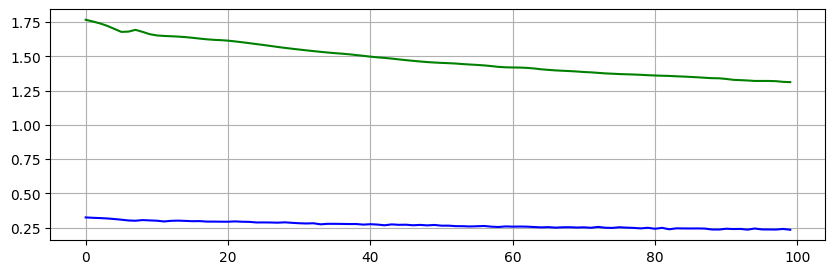

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


CPU times: total: 2min 2s
Wall time: 1min 49s


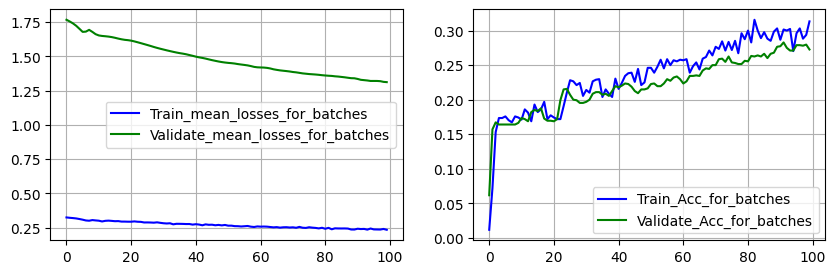

In [80]:
%%time
FIT(model, X_trn, Y_trn)

## Модель с One Hot encoding

Acc_train = 0.2719, Acc_val = 0.2687


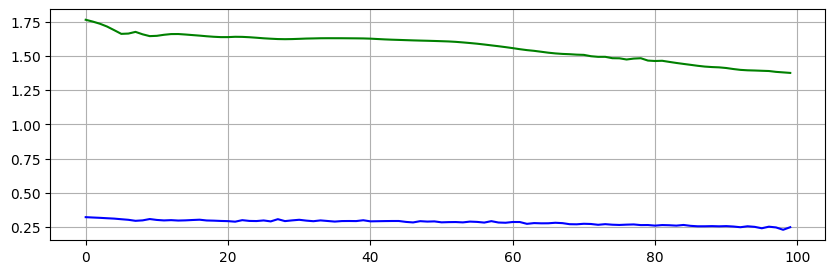

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]


CPU times: total: 1min 31s
Wall time: 57.8 s


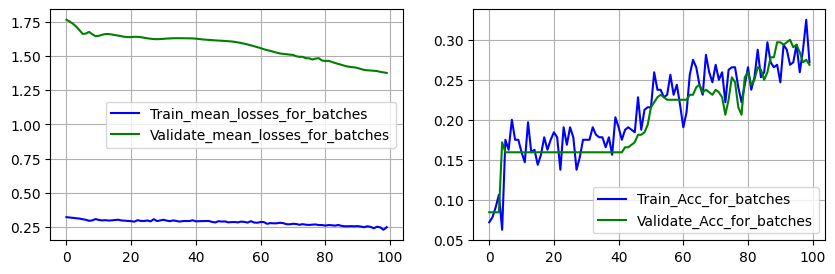

In [55]:
%%time
E_DIM, H_DIM, NUM_LAYERS, DROP = len(CHARS), 250, 2, 0.0
model_one_hot = Model(len(CHARS), E_DIM, H_DIM, NUM_LAYERS, DROP).to(device)
optimazer = torch.optim.Adam(model_one_hot.parameters(), lr = 1e-3, betas = (0.9, 0.999))
CE_loss = torch.nn.CrossEntropyLoss(weight.to(device),)

FIT(model_one_hot, X_trn, Y_trn, mode = 2)

In [88]:
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce 940MX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB


In [89]:
#Проверка что параметры модели на GPU
next(model.parameters()).is_cuda

True

In [90]:
#Почистим кеш на GPU
torch.cuda.empty_cache()

In [59]:
#Хотим получить вектор эмбединга слова от перво медели:
print(model.emb.weight.shape)
for i,char in enumerate(CHARS):
    print('буква {} = {}'.format(char, [round(i,2) for i in model.emb.weight[i].tolist()]))

torch.Size([35, 10])
буква   = [0.57, 0.13, 1.43, -0.84, 0.87, 1.04, -1.32, -0.3, 1.08, 1.16]
буква . = [-1.03, -2.53, 0.12, 0.24, -0.51, 0.73, -0.64, 0.33, -0.65, 0.38]
буква а = [0.56, -0.8, -0.1, 0.06, -0.76, -2.85, -0.75, -2.54, 0.38, -0.21]
буква б = [1.29, 1.02, -0.39, 0.54, 0.84, 0.81, 0.42, -1.07, 1.78, -1.14]
буква в = [1.37, 0.21, 0.84, -1.61, -1.17, 1.26, 0.1, 0.79, -0.46, 0.76]
буква г = [0.55, -0.41, -2.29, 0.05, -1.19, -0.12, -1.38, 0.19, -0.25, -0.68]
буква д = [1.02, 1.82, -0.2, -0.55, -0.65, -1.92, 1.03, -0.07, 1.08, 1.93]
буква е = [-0.45, 0.88, 1.01, 0.87, 0.68, -1.65, -0.59, -2.46, 0.34, 0.63]
буква ж = [0.43, -2.09, 0.29, 1.78, 1.43, 0.06, -1.43, 0.15, 0.05, 0.54]
буква з = [-1.0, 0.12, 0.88, -0.28, -0.07, -0.26, 0.43, 0.12, 0.31, -1.11]
буква и = [0.75, 1.23, -0.71, 0.17, 0.12, 1.89, -1.31, -0.69, 0.1, 0.11]
буква й = [2.09, -0.21, 1.16, -0.65, -0.25, -0.79, -0.74, 0.3, 0.08, -0.63]
буква к = [-2.57, 1.5, 0.04, 0.96, 0.87, -1.24, -0.15, -0.79, -0.74, -2.26]
буква 

Как теперь предсказать буквы вперед?

In [84]:
future = 40
X_in, i = [], 0
while len(X_in)!=LENGTH+future:
    c = text[i]
    if c in CHARS: 
        X_in.append(CHARSID[c])
    i+=1

In [85]:
def Future_chars(model):
    print(tuple([text[:LENGTH] + ' | ' + text[LENGTH:LENGTH + future]]) )
    OUT = []
    for i in range(future):
        future_char = model(torch.tensor(X_in[i:i+LENGTH], dtype = torch.long)[None,:].to(device), NUM = 1)
        future_char = CHARS[torch.argmax(nn.Softmax(dim=1)(future_char[0]), dim = 1).squeeze().item()]
        OUT.append(future_char)
        print(tuple([text[:LENGTH] + '|' + ''.join(OUT)]))

In [87]:
Future_chars(model)

('три девицы под окном \nпря | ли поздно вечерком. \n"кабы я была царица',)
('три девицы под окном \nпря|с',)
('три девицы под окном \nпря|се',)
('три девицы под окном \nпря|сет',)
('три девицы под окном \nпря|сетв',)
('три девицы под окном \nпря|сетво',)
('три девицы под окном \nпря|сетвор',)
('три девицы под окном \nпря|сетворе',)
('три девицы под окном \nпря|сетворее',)
('три девицы под окном \nпря|сетворееи',)
('три девицы под окном \nпря|сетворееий',)
('три девицы под окном \nпря|сетворееий\n',)
('три девицы под окном \nпря|сетворееий\nо',)
('три девицы под окном \nпря|сетворееий\nод',)
('три девицы под окном \nпря|сетворееий\nоде',)
('три девицы под окном \nпря|сетворееий\nодет',)
('три девицы под окном \nпря|сетворееий\nодети',)
('три девицы под окном \nпря|сетворееий\nодетии',)
('три девицы под окном \nпря|сетворееий\nодетиий',)
('три девицы под окном \nпря|сетворееий\nодетиий ',)
('три девицы под окном \nпря|сетворееий\nодетиий  ',)
('три девицы под окном \nпря|сетворееий\nоде

In [63]:
Future_chars(model_one_hot)

('три девицы под окном \nпря | ли поздно вечерком. \n"кабы я была царица',)
('три девицы под окном \nпря|е',)
('три девицы под окном \nпря|ев',)
('три девицы под окном \nпря|евв',)
('три девицы под окном \nпря|евво',)
('три девицы под окном \nпря|еввоа',)
('три девицы под окном \nпря|еввоав',)
('три девицы под окном \nпря|еввоавв',)
('три девицы под окном \nпря|еввоаввг',)
('три девицы под окном \nпря|еввоаввгщ',)
('три девицы под окном \nпря|еввоаввгщщ',)
('три девицы под окном \nпря|еввоаввгщщу',)
('три девицы под окном \nпря|еввоаввгщщуш',)
('три девицы под окном \nпря|еввоаввгщщушш',)
('три девицы под окном \nпря|еввоаввгщщушшц',)
('три девицы под окном \nпря|еввоаввгщщушшцъ',)
('три девицы под окном \nпря|еввоаввгщщушшцъы',)
('три девицы под окном \nпря|еввоаввгщщушшцъыъ',)
('три девицы под окном \nпря|еввоаввгщщушшцъыъв',)
('три девицы под окном \nпря|еввоаввгщщушшцъыъве',)
('три девицы под окном \nпря|еввоаввгщщушшцъыъвее',)
('три девицы под окном \nпря|еввоаввгщщушшцъыъвеею',)
